In [9]:
import xarray as xr
import matplotlib.pyplot as plt
from jupyterthemes import jtplot

plt.style.use('fivethirtyeight')

In [10]:
summafile='/gpfs/fs1/work/manab/fcast/basins/06279940/output/out/summaout.nc'
routefile='/gpfs/fs1/work/manab/fcast/basins/06279940/output/out/summaroute.nc'
obsfile='/gpfs/fs1/work/manab/fcast/basins/obs/06279940_obs.nc'

sid = 12794905 #Outlet segment
hid = 100800120303  #HUC-12 immediately upstream to outlet

stime='2010-03-01'
etime='2014-12-31'

In [11]:
runoff = xr.open_dataset(summafile).set_index(hru='hruId')
route = xr.open_dataset(routefile).set_index(seg='reachID')
obs = xr.open_dataset(obsfile)

print('List of SUMMA output variables: \n' + str(list(runoff.variables)) + '\n')
print('List of mizuRoute output variables: \n' + str(list(route.variables)))

List of SUMMA output variables: 
['time', 'hru', 'pptrate', 'airtemp', 'nSnow', 'nSoil', 'nLayers', 'scalarCanopyIce', 'scalarCanopyLiq', 'scalarSWE', 'mLayerTemp', 'mLayerVolFracLiq', 'scalarAquiferStorage', 'scalarTotalSoilLiq', 'scalarTotalSoilIce', 'scalarTotalSoilWat', 'scalarCanopySublimation', 'scalarSnowSublimation', 'scalarCanopyTranspiration', 'scalarCanopyEvaporation', 'scalarGroundEvaporation', 'scalarRainPlusMelt', 'scalarSoilBaseflow', 'scalarSoilDrainage', 'scalarAquiferRecharge', 'scalarAquiferTranspire', 'scalarAquiferBaseflow', 'averageInstantRunoff']

List of mizuRoute output variables: 
['time', 'basinID', 'basRunoff', 'instRunoff', 'dlayRunoff', 'sumUpstreamRunoff', 'KWTroutedRunoff', 'IRFroutedRunoff', 'seg']


In [12]:
units = {
    "pptrate":3600,                   #kg m-2 s-1 -> mm/hr  
    "averageInstantRunoff":3600000,   #m/s to mm/h
    "scalarAquiferBaseflow":3600000,  #m/s to mm/h
    "scalarRainPlusMelt":3600000,     #m/s to mm/h
    "scalarAquiferRecharge":3600000,  #m/s to mm/h
    "scalarAquiferStorage":1000,      #m to mm
    "scalarAquiferTranspire":3600000, #m/s to mm/h
    "scalarSurfaceRunoff":3600000,    #m/s to mm/h
    "basRunoff":3600000,              #m/s to mm/h
}

def unitConvert(ncdat, ncvar):
    '''
    Converts units of all SUMMA outputs to mm scale
    
    ncdat: netCDF data
    ncvar: variable to be converted
    '''
    ncdat[ncvar] = ncdat[ncvar]*units[ncvar]
    
unitConvert(runoff, 'pptrate')
unitConvert(runoff, 'averageInstantRunoff')
unitConvert(runoff, 'scalarAquiferStorage')
unitConvert(runoff, 'scalarAquiferBaseflow')
unitConvert(runoff, 'scalarAquiferTranspire')
unitConvert(runoff, 'scalarRainPlusMelt')
unitConvert(runoff, 'scalarAquiferRecharge')
unitConvert(route, 'basRunoff')

In [13]:
def subplotCreator(ncdat, ylab, plotnumber):
    ncdat.plot(ax=axarr[plotnumber])
    axarr[plotnumber].set_title('')
    axarr[plotnumber].set_xlabel('')
    axarr[plotnumber].set_ylabel(ylab, rotation='horizontal')
    axarr[plotnumber].yaxis.set_label_coords(-0.25, 0.25)

pptrate=runoff.sel(hru=hid)['pptrate'].loc[stime:etime]
rainmelt=runoff.sel(hru=hid)['scalarRainPlusMelt'].loc[stime:etime]
airtemp=runoff.sel(hru=hid)['airtemp'].loc[stime:etime]
swe=runoff.sel(hru=hid)['scalarSWE'].loc[stime:etime]
sm=runoff.sel(hru=hid)['scalarTotalSoilWat'].loc[stime:etime]
aqstorage=runoff.sel(hru=hid)['scalarAquiferStorage'].loc[stime:etime]
aqrecharge=runoff.sel(hru=hid)['scalarAquiferRecharge'].loc[stime:etime]
aqbaseflow=runoff.sel(hru=hid)['scalarAquiferBaseflow'].loc[stime:etime]
hucrunoff=runoff.sel(hru=hid)['averageInstantRunoff'].loc[stime:etime]
streamflow=route.sel(seg=sid)['KWTroutedRunoff'].loc[stime:etime]

route2=route.copy()
nhdrunoff=route2.set_index(hru='basinID').sel(hru=sid)['basRunoff'].loc[stime:etime]

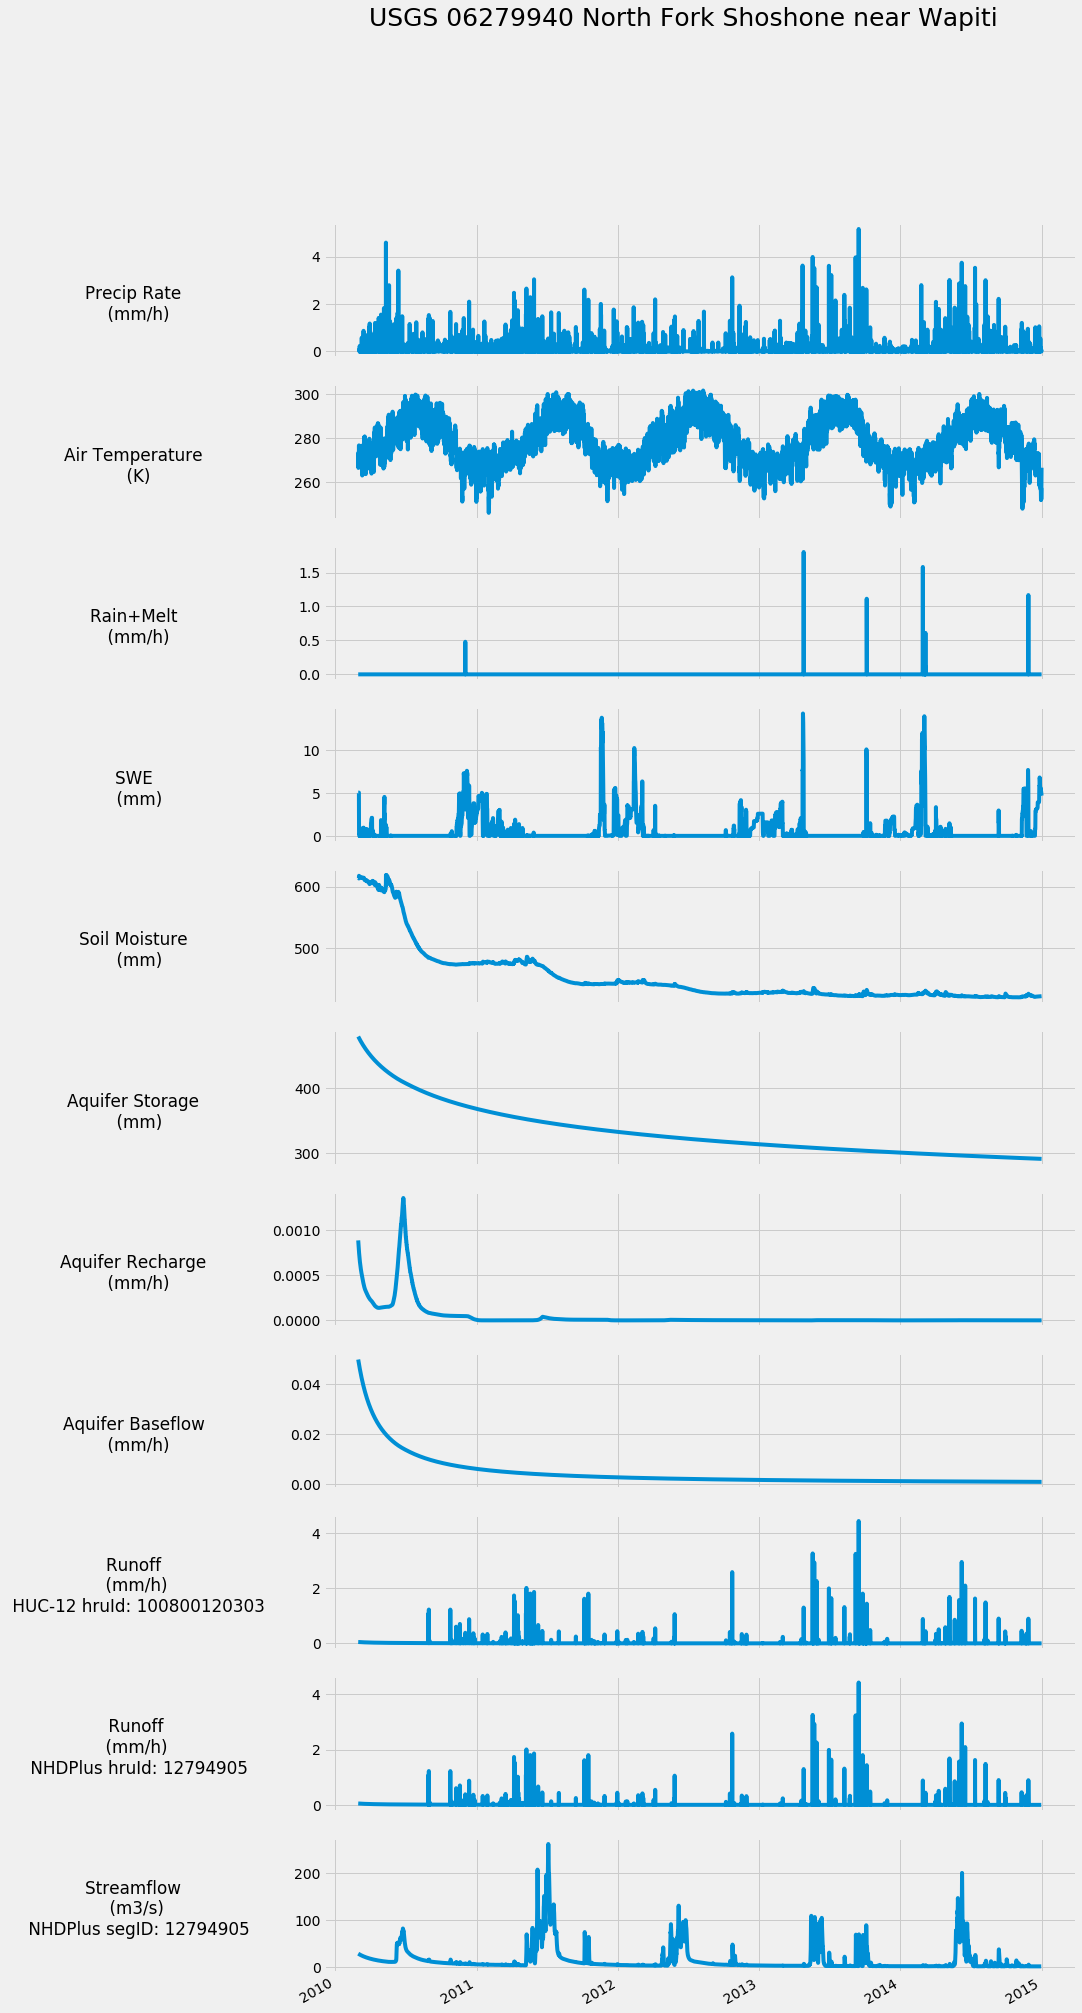

In [14]:
fig, axarr = plt.subplots(nrows=11, figsize=(12,30), sharex=True)
fig.suptitle("USGS 06279940 North Fork Shoshone near Wapiti ", size=25)

subplotCreator(pptrate, 'Precip Rate \n (mm/h)', 0)
subplotCreator(airtemp, 'Air Temperature \n (K)', 1)
subplotCreator(rainmelt, 'Rain+Melt \n (mm/h)', 2)
subplotCreator(swe, 'SWE \n (mm)', 3)
subplotCreator(sm, 'Soil Moisture \n (mm)', 4)
subplotCreator(aqstorage, 'Aquifer Storage \n (mm)', 5)
subplotCreator(aqrecharge, 'Aquifer Recharge \n (mm/h)', 6)
subplotCreator(aqbaseflow, 'Aquifer Baseflow \n (mm/h)', 7)
subplotCreator(hucrunoff, 'Runoff \n (mm/h) \n HUC-12 hruId: '+str(hid), 8)
subplotCreator(nhdrunoff, ' Runoff \n (mm/h) \n NHDPlus hruId: ' + str(sid), 9)
subplotCreator(streamflow, 'Streamflow \n (m3/s) \n NHDPlus segID: ' + str(sid), 10)

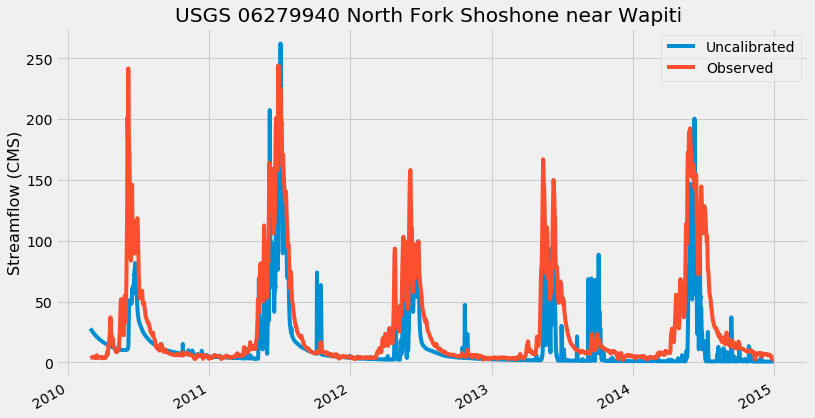

In [15]:
plt.figure(figsize=(12,6))
route.sel(seg=sid)['KWTroutedRunoff'].loc[stime:etime].plot(label="Uncalibrated")
obs['flow'].loc[stime:etime].plot(label="Observed")
plt.title("USGS 06279940 North Fork Shoshone near Wapiti ")
plt.ylabel('Streamflow (CMS)', fontsize=16)
plt.xlabel('')
plt.legend()
plt.show()